# Plot the trends used as inputs for the model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import datetime

Plot the timeframes retrieved for one keyword

In [2]:
topics = {
    "Symptôme": "/m/01b_06"
}

topic_used = "Symptôme"
topic_code = topics[topic_used]
data_hourly_dir = "../data/trends/collect"
geo = "BE"
date_parser = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
df_hourly = {name: pd.read_csv(f"{data_hourly_dir}/{geo}-{name}.csv", parse_dates=['date'], date_parser=date_parser).set_index('date') for name in topics}
df_hourly[topic_used]

,/m/01b_06,batch_id
date,,
2020-02-01 00:00:00,73,0
2020-02-01 01:00:00,82,0
2020-02-01 02:00:00,86,0
2020-02-01 03:00:00,83,0
2020-02-01 04:00:00,79,0
...,...,...
2020-11-25 19:00:00,48,39
2020-11-25 20:00:00,48,39
2020-11-25 21:00:00,55,39


## All hourly batches retrieved

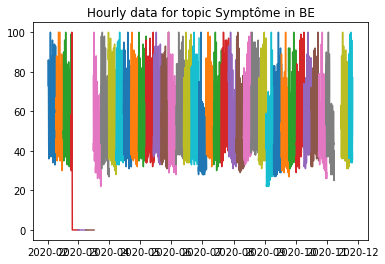

In [3]:
batch_id = df_hourly[topic_used]["batch_id"].unique()
plt.figure()
for i in batch_id:
    df = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == i]
    plt.plot(df[topics[topic_used]])
plt.title(f"Hourly data for topic {topic_used} in {geo}")
plt.show()

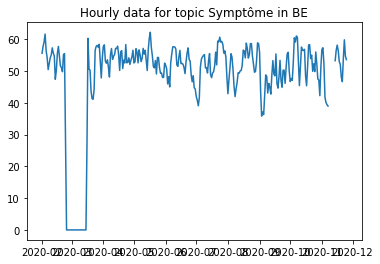

In [4]:
df_hourly_agg = {k: df_hourly[k].resample('D').mean() for k in topics}
plt.figure()
plt.plot(df_hourly_agg[topic_used][topics[topic_used]])
plt.title(f"Hourly data for topic {topic_used} in {geo}")
plt.show()

In [5]:
def merge_trends_batches(left, right, overlap_hour, topic):
    """
    return the concatenation of left and right, correctly scaled based on their overlap (in hours)

    :param left: accumulator dataframe
    :param right: new dataframe to add to the accumulator
    :param overlap_hour: number of hours that are overlapping
    :param topic: topic considered
    """
    if left.empty:
        return right
    # retrieve the overlapping points:
    overlap_start = right.index.min()
    overlap_end = overlap_start + datetime.timedelta(hours=overlap_hour-1)
    left_overlap = left[overlap_start:overlap_end]
    right_overlap = right[overlap_start:overlap_end]
    scaling = (left_overlap[topic] / right_overlap[topic]).mean()
    if scaling < 1:  # right has not the good scale
        right_to_add = right[right.index > overlap_end]
        right_to_add = right_to_add * scaling
        return left.append(right_to_add)
    else:  # left has not the good scale
        left_to_add = left[left.index < overlap_start]
        left_to_add = left_to_add / scaling
        return left_to_add.append(right)
    
def scale_df(df, topic):
    """
    Return a list of the scaled df. If there is always an overlap, the list contains one df.
    Otherwhise, the list contains as many df as there are clusters of periods without missing data
    Each df has its first datetime beginning at 0h and its last datetime ending at 23h
    """
    batch_id = df["batch_id"].to_list()
    def f7(seq):
        seen = set()
        seen_add = seen.add
        return [x for x in seq if not (x in seen or seen_add(x))]
    batch_id = f7(batch_id)
    list_scaled_df = []
    scaled_df = pd.DataFrame()
    for i, j in enumerate(batch_id):
        if j < 0:  # the batch id was not valid
            if not scaled_df.empty:
                list_scaled_df.append(scaled_df)
            scaled_df = pd.DataFrame()
            continue
        
        batch_df = df[df["batch_id"] == j]
        index_overlap = scaled_df.index.intersection(batch_df.index)
        overlap_hours = len(index_overlap)
        overlap_left = scaled_df.loc[index_overlap]
        overlap_right = batch_df.loc[index_overlap]
        if overlap_hours == 0 and scaled_df.empty:
            scaled_df = merge_trends_batches(scaled_df, batch_df, overlap_hours, topic)
        elif (overlap_left[topic] * overlap_right[topic]).sum() == 0: # cannot perform the merge
            list_scaled_df.append(scaled_df)
            scaled_df = batch_df
        else:
            scaled_df = merge_trends_batches(scaled_df, batch_df, overlap_hours, topic)
    list_scaled_df.append(scaled_df)
    
    # drop the period at the beginning and the end, in order to begin from YYYY-MM-DD:0h ->
    for i in range(len(list_scaled_df)):
        df = list_scaled_df[i]
        old_begin, old_end = df.index.min(), df.index.max()
        new_begin = old_begin + datetime.timedelta(hours=((24-old_begin.hour)%24))
        new_end = old_end - datetime.timedelta(hours=((old_end.hour+1)%24))
        list_scaled_df[i] = df[new_begin:new_end]
    return list_scaled_df

## Scaling test

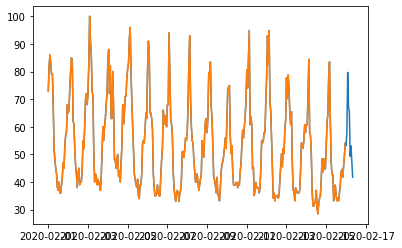

In [6]:
df_1 = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == 0]
df_2 = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == 1]
overlap = len(df_1.index.intersection(df_2.index))
inter = df_1.index.intersection(df_2.index)
plt.plot(merge_trends_batches(df_1, df_2, overlap, topic_code)[topic_code])
df_test = df_hourly[topic_used][(df_hourly[topic_used]["batch_id"] == 0) | (df_hourly[topic_used]["batch_id"] == 1)]
df_test = scale_df(df_test, topic_code)
plt.plot(df_test[0][topic_code])

## Real test: scale and aggregate hourly data

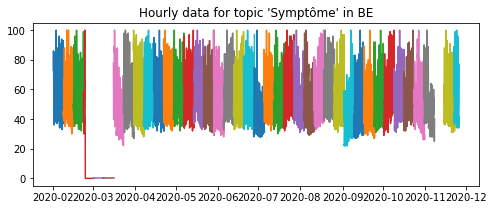

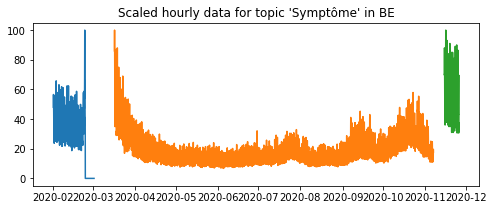

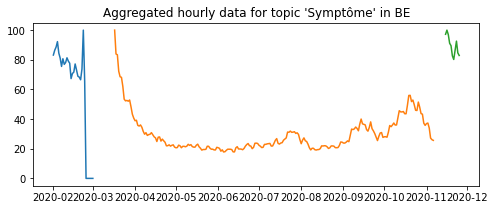

In [7]:
plt.figure(figsize=(8,3))
for i in batch_id:
    df = df_hourly[topic_used][df_hourly[topic_used]["batch_id"] == i]
    plt.plot(df[topics[topic_used]])
plt.title(f"Hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly.png", dpi=300)
plt.show()
plt.figure(figsize=(8,3))

scaled_df = scale_df(df_hourly[topic_used], topic_code)
for df in scaled_df:
    plt.plot(df[topic_code])
plt.title(f"Scaled hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly_scaled.png", dpi=300)
plt.show()

plt.figure(figsize=(8,3))
for df in scaled_df:
    values = df[topic_code].resample('D').mean()
    plt.plot(values * 100 / max(values))
plt.title(f"Aggregated hourly data for topic '{topic_used}' in {geo}")
#plt.savefig("hourly_aggregated.png", dpi=300)
plt.show()

# Retrieve missing days needed for normalization
Read the dataframe and return the list of timeframe needed in order to normalize the whole dataframe

In [8]:
def timeframe_normalize_clusters(list_df, overlap_days=5):
    """
    take as input the list of df given by scale_df and return the list of dates needed to normalize 
    the whole set of data, as tuple of dates
    """
    list_tf = []
    delta = datetime.timedelta(days=overlap_days)
    for df_i, df_j in zip(list_df, list_df[1:]):
        begin = (df_i.index.max() - delta).to_pydatetime()
        end = (df_j.index.min() + delta).to_pydatetime()
        list_tf.append((begin, end))
    return list_tf
print(timeframe_normalize_clusters(scaled_df))

[(datetime.datetime(2020, 2, 25, 23, 0), datetime.datetime(2020, 3, 22, 0, 0)), (datetime.datetime(2020, 11, 1, 23, 0), datetime.datetime(2020, 11, 20, 0, 0))]


# Inspect difference between hourly and daily data
Hourly and daily data are not retrieved with the same API calls. We compare hourly data, scaled and aggregated into days, against daily data. The results should be somewhat similar on the time interval

In [9]:
timeframe_1 = "2020-05-01T0 2020-05-07T23"
timeframe_2 = "2020-05-15T0 2020-05-21T23"
pytrends = TrendReq()
pytrends.build_payload([topic_code], timeframe=timeframe_1, geo="BE")
df_1 = pytrends.interest_over_time()
pytrends.build_payload([topic_code], timeframe=timeframe_2, geo="BE")
df_2 = pytrends.interest_over_time()

In [10]:
timeframe_interval = "2020-04-30 2020-05-22"
pytrends = TrendReq(retries=2, backoff_factor=0.1)
pytrends.build_payload([topic_code], timeframe=timeframe_interval, geo="BE")
df_interval_no_rolling = pytrends.interest_over_time()
df_interval_no_rolling = df_interval_no_rolling[topic_code]

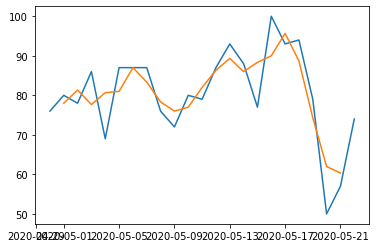

In [11]:
plt.plot(df_interval_no_rolling)
df_interval = df_interval_no_rolling.rolling(3, center=True).mean().dropna()
plt.plot(df_interval)

Retrieve daily data using as less days for the interval as possible

In [12]:
from time import sleep

def mean_query(number, begin, end, topic, geo, cat=0):
    """
    provide multiple queries on the period begin->end. the column topic contains the mean of the queries
    the queries use different interval in order to provide different results
    """
    def dates_to_timeframe(a, b):
        return f"{a.strftime('%Y-%m-%d')} {b.strftime('%Y-%m-%d')}"
    
    def timeframe_iterator():
        """
        yield different timeframes such that [begin, end] is always in the timeframe provided
        uses the closest dates possible to provide the right number of timeframe
        """
        # maximum date allowed for google trends
        max_end = datetime.datetime.today() - datetime.timedelta(days=4)
        lag = int(np.ceil(np.sqrt(number)))
        max_end_lag = (max_end - end).days + 1
        
        # compute possible end and corresponding beginning
        if lag > max_end_lag:
            lag_end = max_end_lag
            lag_begin = int(np.ceil(number / lag_end))
        else:
            lag_begin = lag
            lag_end = lag
            
        # yield timeframes
        for i in range(lag_begin):
            for j in range(lag_end):
                begin_tf = begin - datetime.timedelta(days=i)
                end_tf = end + datetime.timedelta(days=j)
                yield dates_to_timeframe(begin_tf, end_tf)
    
    df_tot = pd.DataFrame()
    cnt = 0
    pytrends = TrendReq(retries=2, backoff_factor=0.1)
    for k, timeframe in enumerate(timeframe_iterator()):
        done = False
        print(f"timeframe= {timeframe} ({k+1}/{number})")
        while not done:
            try:
                pytrends.build_payload([topic], timeframe=timeframe, geo=geo, cat=cat)
                df = pytrends.interest_over_time()
                done = True
            except:
                sleep(10 + 10 * np.random.random())
        df = df[begin:end]
        sleep(1 + np.random.random())
        if 100 not in df[topic]:
            df[topic] = df[topic] * 100 / df[topic].max()
        df_tot[f"{topic}_{cnt}"] = df[topic]
        cnt += 1
        if cnt >= number:
            df_tot[topic_code] = df_tot.mean(axis=1)
            df_tot[topic_code] = 100 * df_tot[topic_code] / df_tot[topic_code].max()
            return df_tot

begin = datetime.datetime.strptime("2020-04-25", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-05-26", "%Y-%m-%d")
df_interval = mean_query(100, begin, end, topic_code, geo)

timeframe= 2020-04-25 2020-05-26 (1/100)
timeframe= 2020-04-25 2020-05-27 (2/100)
timeframe= 2020-04-25 2020-05-28 (3/100)
timeframe= 2020-04-25 2020-05-29 (4/100)
timeframe= 2020-04-25 2020-05-30 (5/100)
timeframe= 2020-04-25 2020-05-31 (6/100)
timeframe= 2020-04-25 2020-06-01 (7/100)
timeframe= 2020-04-25 2020-06-02 (8/100)
timeframe= 2020-04-25 2020-06-03 (9/100)
timeframe= 2020-04-25 2020-06-04 (10/100)
timeframe= 2020-04-24 2020-05-26 (11/100)
timeframe= 2020-04-24 2020-05-27 (12/100)
timeframe= 2020-04-24 2020-05-28 (13/100)
timeframe= 2020-04-24 2020-05-29 (14/100)
timeframe= 2020-04-24 2020-05-30 (15/100)
timeframe= 2020-04-24 2020-05-31 (16/100)
timeframe= 2020-04-24 2020-06-01 (17/100)
timeframe= 2020-04-24 2020-06-02 (18/100)
timeframe= 2020-04-24 2020-06-03 (19/100)
timeframe= 2020-04-24 2020-06-04 (20/100)
timeframe= 2020-04-23 2020-05-26 (21/100)
timeframe= 2020-04-23 2020-05-27 (22/100)
timeframe= 2020-04-23 2020-05-28 (23/100)
timeframe= 2020-04-23 2020-05-29 (24/100)
t

In [13]:
df_interval

,/m/01b_06_0,/m/01b_06_1,/m/01b_06_2,/m/01b_06_3,/m/01b_06_4,/m/01b_06_5,/m/01b_06_6,/m/01b_06_7,/m/01b_06_8,/m/01b_06_9,...,/m/01b_06_91,/m/01b_06_92,/m/01b_06_93,/m/01b_06_94,/m/01b_06_95,/m/01b_06_96,/m/01b_06_97,/m/01b_06_98,/m/01b_06_99,/m/01b_06
date,,,,,,,,,,,,,,,,,,,,,
2020-04-25,94.0,86.0,91.0,74.0,84.0,72.0,88.0,70.0,100.0,76.0,...,73.913043,78.082192,69.318182,93.506494,79.518072,78.048780,79.411765,68.085106,79.775281,86.377243
2020-04-26,90.0,76.0,90.0,96.0,82.0,100.0,83.0,100.0,96.0,86.0,...,98.913043,97.260274,100.000000,88.311688,96.385542,85.365854,94.117647,93.617021,87.640449,97.228145
2020-04-27,89.0,59.0,83.0,85.0,89.0,74.0,77.0,81.0,66.0,78.0,...,80.434783,84.931507,81.818182,84.415584,89.156627,74.390244,83.823529,84.042553,83.146067,88.331269
2020-04-28,80.0,66.0,87.0,82.0,74.0,61.0,81.0,60.0,70.0,76.0,...,63.043478,97.260274,67.045455,100.000000,93.975904,92.682927,83.823529,70.212766,69.662921,87.405334
2020-04-29,96.0,91.0,82.0,90.0,91.0,62.0,77.0,70.0,81.0,87.0,...,65.217391,86.301370,77.272727,92.207792,84.337349,75.609756,86.764706,75.531915,84.269663,88.012931
2020-04-30,92.0,77.0,82.0,88.0,89.0,61.0,89.0,65.0,65.0,85.0,...,81.521739,94.520548,80.681818,81.818182,87.951807,84.146341,88.235294,72.340426,80.898876,90.855381
2020-05-01,85.0,69.0,80.0,89.0,91.0,57.0,83.0,58.0,60.0,83.0,...,67.391304,89.041096,75.000000,84.415584,79.518072,76.829268,83.823529,68.085106,75.280899,86.015154
2020-05-02,81.0,68.0,84.0,84.0,82.0,52.0,81.0,65.0,65.0,78.0,...,60.869565,83.561644,69.318182,71.428571,75.903614,74.390244,66.176471,68.085106,76.404494,83.811446
2020-05-03,96.0,89.0,84.0,83.0,84.0,59.0,80.0,86.0,96.0,91.0,...,100.000000,91.780822,79.545455,98.701299,100.000000,95.121951,92.647059,73.404255,85.393258,95.247401


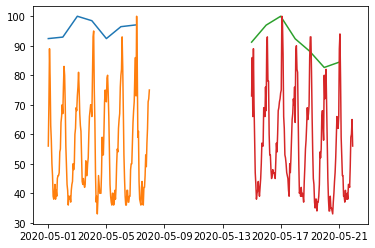

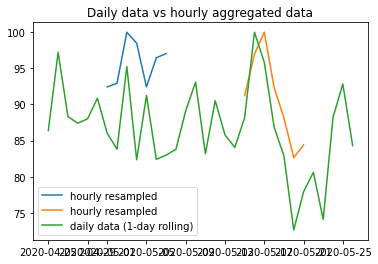

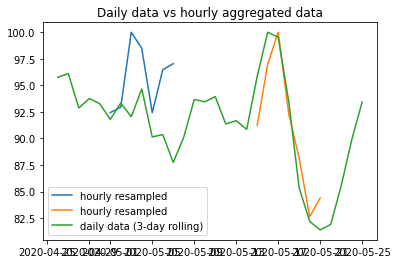

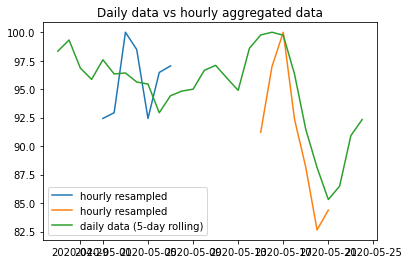

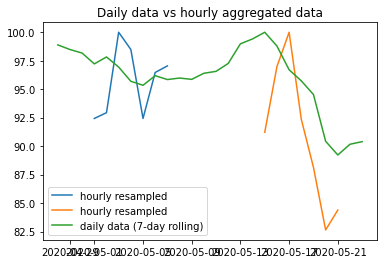

In [14]:
df_1_agg = df_1[topic_code].resample('D').mean()
df_1_agg = df_1_agg * 100 / df_1_agg.max()
df_2_agg = df_2[topic_code].resample('D').mean()
df_2_agg = df_2_agg * 100 / df_2_agg.max()
plt.figure()
plt.plot(df_1_agg)
plt.plot(df_1[topic_code])
plt.plot(df_2_agg)
plt.plot(df_2[topic_code])
plt.show()

for i in [1, 3, 5, 7]:
    df = df_interval_no_rolling.rolling(i, center=True).mean().dropna()
    df = df * 100 / df.max()
    plt.figure()
    plt.plot(df_1_agg, label="hourly resampled")
    plt.plot(df_2_agg, label="hourly resampled")
    rolled_after = df_interval[topic_code].rolling(i, center=True).mean().dropna()
    rolled_after = rolled_after * 100 / rolled_after.max()
    plt.plot(rolled_after, label=f"daily data ({i}-day rolling)")
    plt.legend(loc='lower left')
    plt.title("Daily data vs hourly aggregated data")
    plt.show()

In [15]:
print("intersect 1: ratio hourly/daily")
intersect_1 = df_1_agg.index.intersection(df_interval.index)
scaling_1 = []
for date in intersect_1:
    scaling = df_1_agg.loc[date] / df_interval.loc[date]
    scaling_1.append(scaling)
    print(f"  {date.date()}: {scaling}")
print("mean value of ",np.mean(scaling_1), "\n")
    
print("intersect 2: ratio hourly/daily")
intersect_2 = df_2_agg.index.intersection(df_interval.index)
scaling_2 = []
for date in intersect_2:
    scaling = df_2_agg.loc[date] / df_interval.loc[date]
    scaling_2.append(scaling)
    print(f"  {date.date()}: {scaling}")
print("mean value of ",np.mean(scaling_2))

intersect 1: ratio hourly/daily
  2020-05-01: /m/01b_06_0     1.087408
/m/01b_06_1     1.339561
/m/01b_06_2     1.155371
/m/01b_06_3     1.038536
/m/01b_06_4     1.015711
                  ...   
/m/01b_06_96    1.203053
/m/01b_06_97    1.102670
/m/01b_06_98    1.357561
/m/01b_06_99    1.227798
/m/01b_06       1.074575
Name: 2020-05-01 00:00:00, Length: 101, dtype: float64
  2020-05-02: /m/01b_06_0     1.147338
/m/01b_06_1     1.366682
/m/01b_06_2     1.106362
/m/01b_06_3     1.106362
/m/01b_06_4     1.133346
                  ...   
/m/01b_06_96    1.249282
/m/01b_06_97    1.404342
/m/01b_06_98    1.364974
/m/01b_06_99    1.216347
/m/01b_06       1.108851
Name: 2020-05-02 00:00:00, Length: 101, dtype: float64
  2020-05-03: /m/01b_06_0     1.041667
/m/01b_06_1     1.123596
/m/01b_06_2     1.190476
/m/01b_06_3     1.204819
/m/01b_06_4     1.190476
                  ...   
/m/01b_06_96    1.051282
/m/01b_06_97    1.079365
/m/01b_06_98    1.362319
/m/01b_06_99    1.171053
/m/01b_06       